# Overview
- SegNet for image segmentation
- Input: depth image (acquired via Kinect camera)
- Output: hand components

# Import libraries

In [1]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute
from keras.optimizers import Adam

import os, time, numpy as np, matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [2]:
n_classes = 7
kernel = 3
img_h = img_w = 96

# (1) Data

#### Hand images: https://drive.google.com/file/d/1MRiBnDW9dE7mNb5bL-jzhmtTd2CSklvL/view?usp=sharing

In [3]:
def prepare_segnet_data(root_path):
    loi = os.listdir(root_path)

    data_x = np.zeros((int(len(loi)), img_h, img_w, 1))
    data_y = np.zeros((int(len(loi)), img_h, img_w, n_classes), dtype=np.uint8)

    for im_ind, fn in enumerate(loi):
        def gray2classes(label_img, img_h=96, img_w=96, n_classes=7):
            label_img_oh = np.zeros((img_h, img_w, n_classes), dtype=np.uint8)

            def get_oh(label_img, class_color):
                oh_tmp = np.zeros((img_h, img_w), dtype=np.uint8)
                oh_tmp[np.where(label_img == class_color)] = 1
                return oh_tmp

            # palm
            class_color = 255
            class_indx = 0
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 1
            class_color = 43
            class_indx = 1
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 2
            class_color = 85
            class_indx = 2
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 3
            class_color = 128
            class_indx = 3
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 4
            class_color = 170
            class_indx = 4
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 5
            class_color = 212
            class_indx = 5
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # background
            class_color = 0
            class_indx = 6
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            return label_img_oh

        fn = os.path.join(root_path, fn)
        labels_fn = fn.replace('depth', 'labels')

        img = np.uint8(resize(imread(fn), (img_h, img_w), order=0, mode='constant', preserve_range=True))
        img = np.expand_dims(img, axis=2)

        label = gray2classes(np.uint8(resize(imread(labels_fn), (img_h, img_w), order=0, mode='constant', preserve_range=True)), img_h=img_h, img_w=img_w, n_classes=n_classes)

        data_x[im_ind, :, :, :] = img
        data_y[im_ind, :, :, :] = label

    data_y = data_y.reshape((int(len(loi)), img_h * img_w, n_classes))

    return data_x, data_y

In [4]:
root_path = '/kaggle/input/data-segnet/data/segnet/train/depth'
x_train, y_train = prepare_segnet_data(root_path)

root_path = '/kaggle/input/data-segnet/data/segnet/test/depth'
x_test, y_test = prepare_segnet_data(root_path)

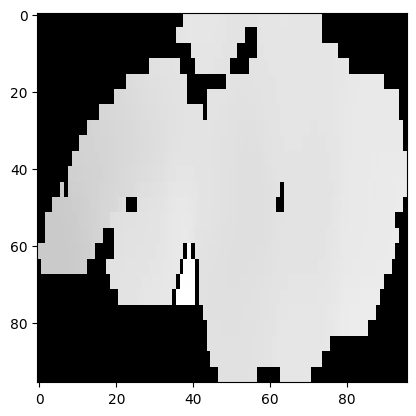

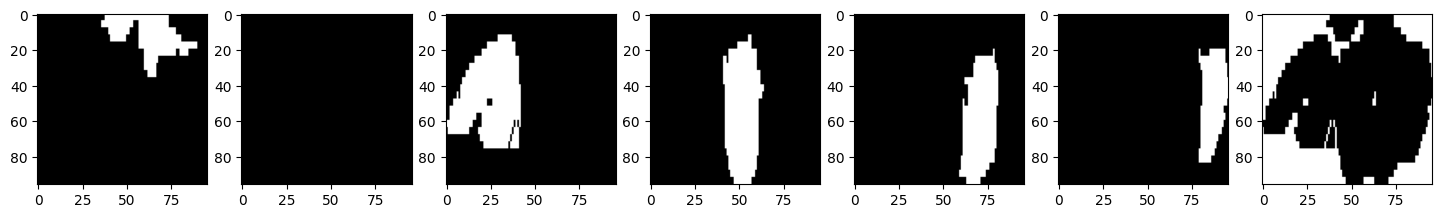

In [5]:
plt.imshow(x_test[1000, :, :, 0], cmap='gray')
plt.show()

plt.figure(figsize=(18, 5))
fin_ind = 1
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 2
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 3
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 4
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 5
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 6
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 7
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
plt.show()

# (2) Declare model

In [6]:
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_classes, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_classes, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 256)         │           1,0

 Total params: 29,458,211 (112.37 MB)

 Trainable params: 29,442,325 (112.31 MB)

 Non-trainable params: 15,886 (62.05 KB)

# (3) Train defined model
- In case your system runs out of memory (OOM), try to use smaller batch size

In [7]:
lr = 0.0001
batch_size = 8
nb_epoch = 15

optimizer = Adam(learning_rate=lr)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

start_time = time.time()

autoencoder.fit(x_train, y_train,
                validation_data=(x_test, y_test),
                batch_size=batch_size, epochs=nb_epoch,
                verbose=1)

training_time = time.time() - start_time
print('> training time: ' + str(training_time) + 's')

Epoch 1/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.5478 - loss: 1.3081 - val_accuracy: 0.6362 - val_loss: 1.0656
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.7213 - loss: 0.8655 - val_accuracy: 0.6849 - val_loss: 0.9031
Epoch 3/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.7724 - loss: 0.7401 - val_accuracy: 0.7194 - val_loss: 0.8487
Epoch 4/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.8092 - loss: 0.6526 - val_accuracy: 0.7391 - val_loss: 0.7895
Epoch 5/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.8339 - loss: 0.5893 - val_accuracy: 0.7457 - val_loss: 0.7823
Epoch 6/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8512 - loss: 0.5394 - val_accuracy: 0.7571 - val_loss: 0.7633
Epoch 7/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8567 - loss: 0.5168 - val_accuracy: 0.7665 - val_loss: 0.7246
Epoch 8/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8716 - loss: 0

# (4) Evaluate trained model

In [8]:
score = autoencoder.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.7821 - loss: 0.6656
Test loss: 0.6733848452568054
Test accuracy: 0.7800704836845398


In [9]:
def class_to_rgb(output_dis):
    rgb_out = np.ones((img_h, img_w, 3), dtype=np.float64)  # Sửa np.float thành np.float64

    rgb_out[np.where(output_dis == 0)] = [0, 0, 0]
    rgb_out[np.where(output_dis == 1)] = [0, 0, 0.5]
    rgb_out[np.where(output_dis == 2)] = [0, 0.5, 0]
    rgb_out[np.where(output_dis == 3)] = [0.5, 0, 0]
    rgb_out[np.where(output_dis == 4)] = [0.5, 0, 0.5]
    rgb_out[np.where(output_dis == 5)] = [0.5, 0.5, 0]
    rgb_out[np.where(output_dis == 6)] = [1, 1, 1]

    return rgb_out

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


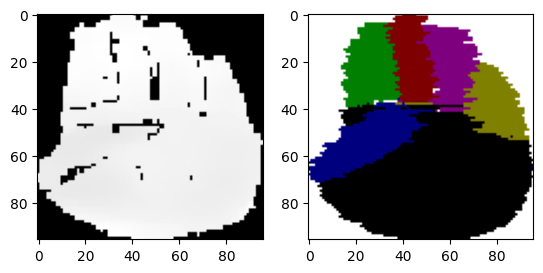

In [10]:
plt.subplot(1, 2, 1)
ran_ind = np.random.choice(range(int(x_test.shape[0])), 1)[0]
plt.imshow(x_test[ran_ind, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
segnet_out = autoencoder.predict(np.expand_dims(np.expand_dims(x_test[ran_ind, :, :, 0], axis=0), axis=3))
segnet_rgb = class_to_rgb(np.argmax(segnet_out.reshape(96, 96, 7), axis=2))
plt.imshow(segnet_rgb)

plt.show()